In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train.pop('survived')
y_test = test.pop('survived')
train

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,female,19.0,0,0,30.0000,First,B,Southampton,y
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


In [ ]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []

#建立one_hot的函式，並回傳indicator，以利feature_importances運算
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

#類別欄位處理
for feature_name in categorical_columns:
  #依據train的feature_name將categorical轉one-hot
  vocabulary = train[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

#數值欄位處理
for feature_name in numeric_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))

In [ ]:
shuffle_buffer_size = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = (dataset
      .repeat(n_epochs) 
      .batch(shuffle_buffer_size))
    return dataset
  return input_fn


train_input_fn = make_input_fn(train, y_train)
test_input_fn = make_input_fn(test, y_test, n_epochs=1,shuffle=False)

In [ ]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
}

#使用BoostedTrees方法
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)

results = est.evaluate(test_input_fn)
pd.Series(results).to_frame()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpro4y91d6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Plea

,0
accuracy,0.814394
accuracy_baseline,0.625000
auc,0.872329
auc_precision_recall,0.855231
average_loss,0.411194
label/mean,0.375000
loss,0.411194
precision,0.765957
prediction/mean,0.385918
recall,0.727273


In [ ]:
#萃取重要特徵
importances = est.experimental_feature_importances(normalize=True)
importances_draw = pd.Series(importances)

sns_draw = importances_draw.to_frame().reset_index()
sns_draw

,index,0
0,sex,0.415218
1,fare,0.179924
2,class,0.152154
3,age,0.125135
4,deck,0.051570
5,embark_town,0.041911
6,n_siblings_spouses,0.026594
7,parch,0.007495
8,alone,0.000000


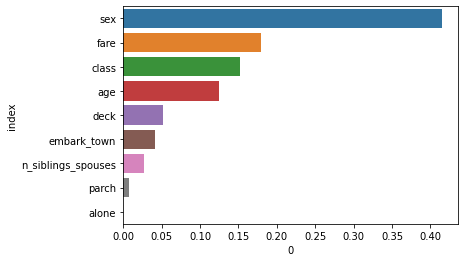

In [ ]:
sns.barplot(x=sns_draw[0],y=sns_draw['index'])

In [ ]:
#sex:性別
#age:年齡
#n_siblings_spouses:船上的兄弟姊妹或配偶數
#parch:船上父母或子女數量
#fare:票價
#class:艙等
#deck:鄰近的甲板
#embark_town:登船的港口
#alone:是否單獨一人